**1. Get current DAX constituents from wikipedia**

In [120]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import time
from tqdm import tqdm

In [2]:
def dax40_latest_constituents():
    
    """
    Retrieves a dataframe of company name, ticker and sector of DAX40 index constituents from the website https://en.wikipedia.org/wiki/DAX.

    Args:
        None

    Returns:
        dataframe: A pandas dataframe of DAX40 with columns: Tickers, Name and Sector
    """

    url = 'https://en.wikipedia.org/wiki/DAX'
    response = requests.get(url)

    #Check if the connection is succesful
    try:
        response = requests.get(url)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
        else:
            raise Exception(f'Cannot reach website {url}')
    except:
        raise Exception(f'Website {url} does not exist')

    #check if table 'constituents' exists
    wiki_table_id = 'constituents'
    try:
        indiatable = soup.find('table',{'id': wiki_table_id,'class':'wikitable'})
        df = pd.read_html(str(indiatable))
    except:
        raise Exception(f'Table {wiki_table_id} cannot be found in {url}')

    #Extract columns from table
    extract_cols = ['Ticker', 'Company', 'Prime Standard Sector']
    try:
        dax_constituents = pd.DataFrame(df[0])[extract_cols]
        dax_constituents = dax_constituents.rename(columns = {'Prime Standard Sector': 'Sector', 'Company': 'Name'})
    except KeyError as e:
        raise Exception((e.args[0]).replace('index', 'column index of table constituents'))

    return dax_constituents

In [3]:
#Test
dax_comp = dax40_latest_constituents()
print(dax_comp.head(5))

    Ticker     Name              Sector
0   ADS.DE   Adidas             Textile
1   AIR.DE   Airbus           Aerospace
2   ALV.DE  Allianz  Financial Services
3   BAS.DE     BASF     Basic Materials
4  BAYN.DE    Bayer          Healthcare


Analyse the table of constituents

<AxesSubplot:xlabel='Sector'>

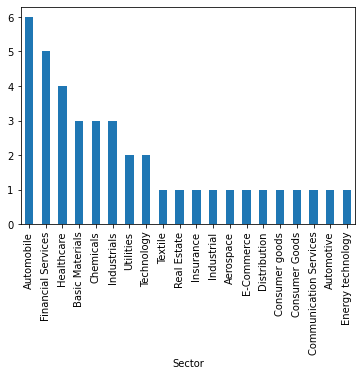

In [4]:
dax_comp.groupby(['Sector'])['Sector'].count().sort_values(ascending=False).plot.bar()

In [5]:
def replace_by_freq(dataframe, column_name, threshold, new_value):

    """
    Replaces values in a column if the frequency of values is less than a threshold

    Args:
        dataframe: A dataframe to be modified
        column_name (str): A column name in dataframe where the replacement will be done
        threshold (int): A cutoff, if any values occur less than a thresshold value they are replaced
        new_value (Union[str, int, float]): A value to be replaced with
    
    Returns:
        dataframe: a dataframe with modified values
    """

    try:
        unique = dataframe.groupby(column_name)[column_name].transform('size').lt(threshold)
        dataframe.loc[unique, column_name] = new_value
    except KeyError as ke:
        print(f'Column ', ke, 'is not found in a dataframe')

        #raise Exception(f'Could not replace values in column {column_name} in dataframe {dataframe}')
    
    return dataframe

In [6]:
dax_comp_replaced = replace_by_freq(dax_comp, 'Sectorr', 2, 'Other')

Column  'Sectorr' is not found in a dataframe


In [7]:
print(dax_comp_replaced)

     Ticker                   Name                  Sector
0    ADS.DE                 Adidas                 Textile
1    AIR.DE                 Airbus               Aerospace
2    ALV.DE                Allianz      Financial Services
3    BAS.DE                   BASF         Basic Materials
4   BAYN.DE                  Bayer              Healthcare
5    BEI.DE             Beiersdorf          Consumer goods
6    BMW.DE                    BMW              Automobile
7    BNR.DE               Brenntag            Distribution
8    CBK.DE            Commerzbank      Financial Services
9    CON.DE            Continental              Automotive
10  1COV.DE               Covestro         Basic Materials
11   DTG.DE          Daimler Truck              Automobile
12   DBK.DE          Deutsche Bank      Financial Services
13   DB1.DE         Deutsche Börse      Financial Services
14   DPW.DE          Deutsche Post             Industrials
15   DTE.DE       Deutsche Telekom  Communication Servic

<AxesSubplot:xlabel='Sector'>

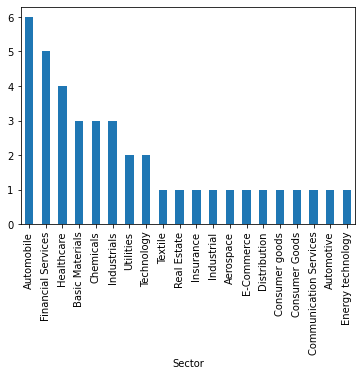

In [8]:
dax_comp_replaced.groupby(['Sector'])['Sector'].count().sort_values(ascending=False).plot.bar()

In [9]:
#A list of tickers from contituents
dax_tickers = dax_comp_replaced['Ticker'].values.tolist()

In [18]:
len(dax_tickers)

40

In [22]:
dax_tickers[:5]

['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE']

Download monthly data from yahoo API

In [209]:
def get_stock_price(ticker, start_date = "2005-01-01", end_date = "2023-01-01", price_interval = '1mo'):

    """
    Returns a pandas series of closed prices from yfinance

    Args:
        ticker (str): A stock identifier in yahoo finance
        start_date (date): Begin of the series
        end_date (date): End of the series
        granularity (str): Frequency of the presented series

    Returns:
        pandas series: a time series of closed prices with timestamp as an index
    """
    interval_types = ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

    if price_interval not in interval_types:
        raise ValueError(f'Unknown interval type: {price_interval}. Acceptable arguments are {interval_types}')
    

    stock_data = yf.Ticker(ticker)
    stock_series = stock_data.history(start = start_date, end = end_date, interval = price_interval).Close

    if stock_series.empty:
        raise ValueError(f'{ticker} either does not exist or does not have data for a given time period')

    return stock_series


In [154]:
dax_tickers_sample = ['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', '1COV.DE']

In [210]:
def get_data(tickers):

    """
    Returns a pandas dataframe with named columns of Close prices from yfinance

    Args:
        tickers (str, List of strings): A stock identifiers in yahoo finance

    Returns:
        pandas dataframe: a time series of closed prices with timestamp as an index and ticker names as columns
    """

    output = {}

    with tqdm(total = len(tickers)) as pbar:
        for one_ticker in tickers:
            pbar.set_postfix_str(one_ticker)
            try:
                stock_price = get_stock_price(ticker = one_ticker)
                output[one_ticker] = stock_price
            except ValueError as e:
                print(e) #substitute with logging
                pass
            pbar.update()
            time.sleep(0.5)
            
    
    return pd.DataFrame(output)

In [205]:
#Create function which deletes columns it at least one null

In [211]:
dax_data = get_data(tickers = dax_tickers)

100%|██████████| 40/40 [00:28<00:00,  1.39it/s, ZAL.DE] 


In [212]:
dax_data.isnull().sum()

ADS.DE       0
AIR.DE       0
ALV.DE       0
BAS.DE       0
BAYN.DE      0
BEI.DE       0
BMW.DE       0
BNR.DE      63
CBK.DE       0
CON.DE       0
1COV.DE    130
DTG.DE     204
DBK.DE       0
DB1.DE       0
DPW.DE       0
DTE.DE       0
EOAN.DE      0
FRE.DE       0
HNR1.DE      0
HEI.DE       0
HEN3.DE      0
IFX.DE       0
MBG.DE       0
MRK.DE       0
MTX.DE       6
MUV2.DE      0
P911.DE    213
PAH3.DE     49
QIA.DE       0
RHM.DE       0
RWE.DE       0
SAP.DE       0
SRT3.DE      0
SIE.DE       0
ENR.DE     189
SHL.DE     160
SY1.DE      24
VOW3.DE      0
VNA.DE     103
ZAL.DE     117
dtype: int64

In [88]:

dax_series = {}

In [ ]:
#Function to retrieve data:
#ok Input list of tickers 
#check it they are strings and is a list
#ok Checks if ticker can be downloaded (is in yahoo finance) 
#ok appends list with data
#ok appends list with ticker name
#retrieves data with 1s time postponment
#if some stocks have nulls -> delete them
#returns a dataframe
#creates logs what tickers have been downloaded
#at least two time series should be to do mvp

,Date,1COV.DE,BMW.DE
0,2000-01-01,NaN,12.122416
1,2000-02-01,NaN,13.694219
2,2000-03-01,NaN,17.027884
3,2000-04-01,NaN,15.204389
4,2000-05-01,NaN,16.745371
...,...,...,...
275,2022-12-01,36.549999,83.379997
276,2023-01-01,42.119999,93.230003
277,2023-02-01,41.650002,97.750000
278,2023-03-01,38.130001,100.940002


,Adj Close,Adj Close
Date,,
2000-01-01,NaN,12.122418
2000-02-01,NaN,13.694222
2000-03-01,NaN,17.027885
2000-04-01,NaN,15.204383
2000-05-01,NaN,16.745367
...,...,...
2022-12-01,36.549999,83.379997
2023-01-01,42.119999,93.230003
2023-02-01,41.650002,97.750000


In [ ]:
import yfinance as yf
import pandas as pd
import logging

def get_data(tickers):
    '''
        Returns a pandas dataframe with named columns of Close prices from yfinance
    '''
    output = {}
    for tick in tickers:
        #use tolist
        try:
            stock_data = get_data_for_ticker(tick)
            output[tick]= stock_data
        except ValueError:
            #in case ticker does not exist
            logging.warning(f'Non-existent ticker {tick}')
            continue
    #make this Pandas DF
    # print(output)
    return pd.DataFrame(output)

def get_data_for_ticker(tick):
    '''
        return array of Close prices
    '''
    temp_stock = yf.Ticker(tick)
    #YTD data
    hist = temp_stock.history()
    close_prices = hist.Close.tolist()
    if len(close_prices)<1:
        raise ValueError(f"No prices - {tick}")

    return close_prices

In [ ]:
get_data_for_ticker('1COV.DE')

[36.470001220703125,
 36.25,
 36.619998931884766,
 35.86000061035156,
 36.77000045776367,
 37.13999938964844,
 37.880001068115234,
 37.79999923706055,
 37.29999923706055,
 37.040000915527344,
 37.13999938964844,
 36.43000030517578,
 37.0,
 36.689998626708984,
 39.790000915527344,
 38.060001373291016,
 38.52000045776367,
 38.130001068115234,
 40.130001068115234]

In [ ]:
get_data(['BMW.DE', '1COV.DEE'])

1COV.DEE: No data found, symbol may be delisted


,BMW.DE
0,99.089996
1,98.620003
2,102.680000
3,102.320000
4,103.680000
5,103.199997
6,104.099998
7,103.779999
8,100.019997
9,100.599998
